<a href="https://colab.research.google.com/github/lilshashini/Paddy_Field_Detector/blob/main/paddy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Detectron2
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/detectron2.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json

# Load the COCO annotations
with open("/content/drive/MyDrive/05.28.L/Detect_paddy/train/_annotations.coco.json") as f:
    coco = json.load(f)

# Update categories: keep only "Not_paddy" and "paddy"
coco["categories"] = [
    {"id": 1, "name": "Not_paddy"},
    {"id": 2, "name": "paddy"}
]

# Filter annotations to include only those with category_id 1 or 2
coco["annotations"] = [
    ann for ann in coco["annotations"] if ann["category_id"] in [1, 2]
]

# Optionally save to a new file
with open("/content/drive/MyDrive/05.28.L/Detect_paddy/train/_annotations_filtered.coco.json", "w") as f:
    json.dump(coco, f, indent=2)

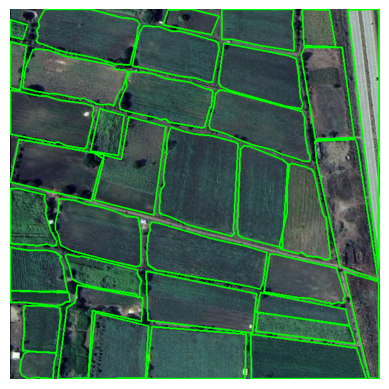

In [ ]:
from detectron2.data.datasets import register_coco_instances
import os
from detectron2.data import MetadataCatalog, DatasetCatalog
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np

dataset_path = "/content/drive/MyDrive/05.28.L/Detect_paddy/train/Geo_img"

# Unregister the dataset if it's already registered
if "paddy_train" in DatasetCatalog:
    DatasetCatalog.remove("paddy_train")
if "paddy_train" in MetadataCatalog:
    MetadataCatalog.remove("paddy_train")

register_coco_instances(
    "paddy_train",
    {},
    os.path.join(dataset_path, "/content/drive/MyDrive/05.28.L/Detect_paddy/train/_annotations_filtered.coco.json"),
    os.path.join(dataset_path, "/content/drive/MyDrive/05.28.L/Detect_paddy/train/Geo_img")
)

dataset_dicts = DatasetCatalog.get("paddy_train")
metadata = MetadataCatalog.get("paddy_train")

sample = random.choice(dataset_dicts)
img = cv2.imread(sample["file_name"])


for anno in sample["annotations"]:
    if "segmentation" in anno:
        for seg in anno["segmentation"]:
            pts = np.array(seg, np.int32).reshape((-1, 1, 2))
            cv2.polylines(img, [pts], isClosed=True, color=(0, 255, 0), thickness=2)  # Green outline


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [ ]:
#model
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()

# Use a higher-performing Mask R-CNN backbone for better accuracy
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

# Dataset
cfg.DATASETS.TRAIN = ("paddy_train",)
cfg.DATASETS.TEST = ()  # Optional: add val set for evaluation

cfg.DATALOADER.NUM_WORKERS = 2

# Output directory
cfg.OUTPUT_DIR = "/content/drive/MyDrive/05.28.L/Detect_paddy/train/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Pretrained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")

# Training settings
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0001  # Lower LR for fine-tuning to avoid overfitting
cfg.SOLVER.MAX_ITER = 3000   # Increase for better convergence
cfg.SOLVER.STEPS = []        # Disable LR decay for now (can tune later)

# ROI settings
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # More RoIs for better training
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2     # Lower threshold to get more predictions
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2             # Set to your class count

# Image size settings (helps boundary resolution)
cfg.INPUT.MIN_SIZE_TRAIN = (800, 1024)
cfg.INPUT.MAX_SIZE_TRAIN = 1333
cfg.INPUT.MIN_SIZE_TEST = 1024
cfg.INPUT.MAX_SIZE_TEST = 1333

# Optional: Add test-time augmentations to improve boundary confidence
cfg.TEST.AUG.ENABLED = True
cfg.TEST.AUG.MIN_SIZES = (800, 1024)
cfg.TEST.AUG.MAX_SIZE = 1333
cfg.TEST.AUG.FLIP = True

# Train
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[05/28 19:20:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:01, 232MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[05/28 19:20:20 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/28 19:20:38 d2.utils.events]:  eta: 0:39:15  iter: 19  total_loss: 4.424  loss_cls: 1.102  loss_box_reg: 0.5268  loss_mask: 0.696  loss_rpn_cls: 1.861  loss_rpn_loc: 0.2561    time: 0.7614  last_time: 0.5783  data_time: 0.0325  last_data_time: 0.0057   lr: 1.9981e-06  max_mem: 3574M
[05/28 19:21:03 d2.utils.events]:  eta: 0:39:07  iter: 39  total_loss: 4.117  loss_cls: 1.085  loss_box_reg: 0.5888  loss_mask: 0.6943  loss_rpn_cls: 1.465  loss_rpn_loc: 0.2449    time: 0.7537  last_time: 0.5872  data_time: 0.0081  last_data_time: 0.0075   lr: 3.9961e-06  max_mem: 3574M
[05/28 19:21:18 d2.utils.events]:  eta: 0:38:58  iter: 59  total_loss: 3.635  loss_cls: 1.038  loss_box_reg: 0.6733  loss_mask: 0.6901  loss_rpn_cls: 0.9954  loss_rpn_loc: 0.2303    time: 0.7567  last_time: 0.8258  data_time: 0.0094  last_data_time: 0.0146   lr: 5.9941e-06  max_mem: 3574M
[05/28 19:21:33 d2.utils.events]:  eta: 0:38:44  iter: 79  total_loss: 3.143  loss_cls: 0.9925  loss_box_reg: 0.726  loss_mask: 0.684

[05/28 20:01:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/05.28.L/Detect_paddy/train/output/model_final.pth ...


  backbone.bottom_up.res4.6.conv1.weight
  backbone.bottom_up.res4.6.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.6.conv2.weight
  backbone.bottom_up.res4.6.conv2.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.6.conv3.weight
  backbone.bottom_up.res4.6.conv3.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.7.conv1.weight
  backbone.bottom_up.res4.7.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.7.conv2.weight
  backbone.bottom_up.res4.7.conv2.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.7.conv3.weight
  backbone.bottom_up.res4.7.conv3.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.8.conv1.weight
  backbone.bottom_up.res4.8.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.8.conv2.weight
  backbone.bottom_up.res4.8.conv2.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res

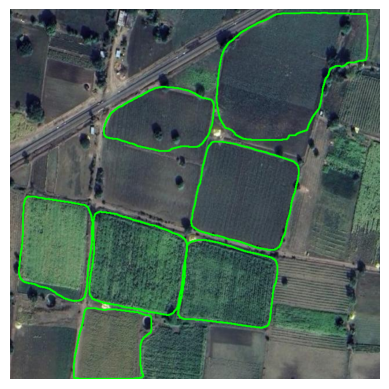

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # Same as during training
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/05.28.L/Detect_paddy/train/output", "model_final.pth")  # Path to your trained model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Confidence threshold
cfg.DATASETS.TEST = ("paddy_train", )  # Optional, for metadata

predictor = DefaultPredictor(cfg)

image_path = "/content/drive/MyDrive/05.28.L/Detect_paddy/train/Geo_img/pic7_png.rf.0784c280dd44fbb13f3d8f84bd2aefe2.jpg"
img = cv2.imread(image_path)

# Make prediction
outputs = predictor(img)
instances = outputs["instances"].to("cpu")
masks = instances.pred_masks.numpy()

for mask in masks:
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.polylines(img, [contour], isClosed=True, color=(0, 255, 0), thickness=2)  # Green outline

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

[05/28 20:02:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/05.28.L/Detect_paddy/train/output/model_final.pth ...


  backbone.bottom_up.res4.6.conv1.weight
  backbone.bottom_up.res4.6.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.6.conv2.weight
  backbone.bottom_up.res4.6.conv2.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.6.conv3.weight
  backbone.bottom_up.res4.6.conv3.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.7.conv1.weight
  backbone.bottom_up.res4.7.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.7.conv2.weight
  backbone.bottom_up.res4.7.conv2.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.7.conv3.weight
  backbone.bottom_up.res4.7.conv3.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.8.conv1.weight
  backbone.bottom_up.res4.8.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.8.conv2.weight
  backbone.bottom_up.res4.8.conv2.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res

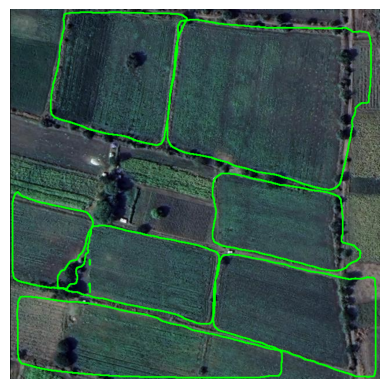

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # Same as during training
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/05.28.L/Detect_paddy/train/output", "model_final.pth")  # Path to your trained model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Confidence threshold
cfg.DATASETS.TEST = ("paddy_train", )  # Optional, for metadata

predictor = DefaultPredictor(cfg)

image_path = "/content/drive/MyDrive/05.28.L/Detect_paddy/train/Geo_img/pic4_png.rf.01f70a40b4e38e88ac68962f1d6dba88.jpg"
img = cv2.imread(image_path)

# Make prediction
outputs = predictor(img)
instances = outputs["instances"].to("cpu")
masks = instances.pred_masks.numpy()

for mask in masks:
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.polylines(img, [contour], isClosed=True, color=(0, 255, 0), thickness=2)  # Green outline

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()